### Imports

In [1]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import matplotlib.pyplot as plt
import numpy as np


### Model Building

**Limit GPU Memory Growth to only what's needed**

In [2]:
import tensorflow as tf 
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Failed to limit GPU memory')

**Gather Pre-proccessed images**

In [3]:
img_size = 512;
train_path = 'dataset-classification/train-segmented'
valid_path = 'dataset-classification/validate-segmented'

train_generator = ImageDataGenerator().flow_from_directory(train_path, target_size=(img_size,img_size))
valid_generator = ImageDataGenerator().flow_from_directory(valid_path, target_size=(img_size,img_size))


Found 4914 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


**Build Model**

In [4]:
base_model = MobileNetV3Large(weights='imagenet', include_top = False, input_shape=(img_size,img_size,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs = preds)

In [5]:
for layers in model.layers[:-35]:
    layers.trainable = False

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 256, 256, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

**Train Model**

In [7]:
epochs = 20

optimizer = Adam(learning_rate = 0.0001)

model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

history = model.fit(train_generator, validation_data=valid_generator, epochs = epochs)

Epoch 1/20
154/154 [==============================] - 100s 562ms/step - loss: 0.2726 - accuracy: 0.9044 - val_loss: 1.8094 - val_accuracy: 0.3967
Epoch 2/20
154/154 [==============================] - 47s 304ms/step - loss: 0.0330 - accuracy: 0.9910 - val_loss: 1.1319 - val_accuracy: 0.6350
Epoch 3/20
154/154 [==============================] - 46s 297ms/step - loss: 0.0152 - accuracy: 0.9961 - val_loss: 0.5812 - val_accuracy: 0.7900
Epoch 4/20
154/154 [==============================] - 47s 307ms/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.5491 - val_accuracy: 0.8267
Epoch 5/20
154/154 [==============================] - 48s 310ms/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 0.3440 - val_accuracy: 0.8950
Epoch 6/20
154/154 [==============================] - 67s 432ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.2300 - val_accuracy: 0.9250
Epoch 7/20
154/154 [==============================] - 55s 356ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.1154 - val_a

### Accuracy and Loss Plots

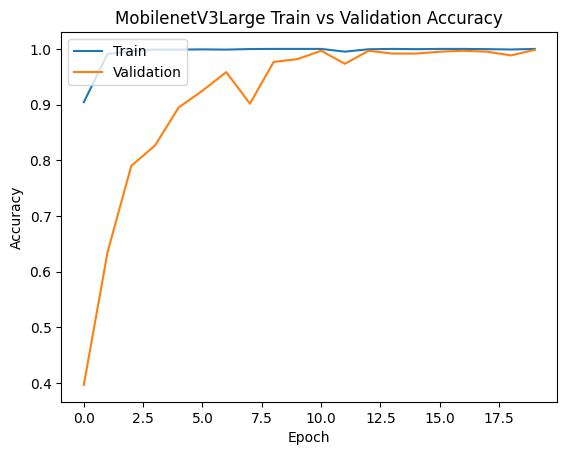

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MobilenetV3Large Train vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

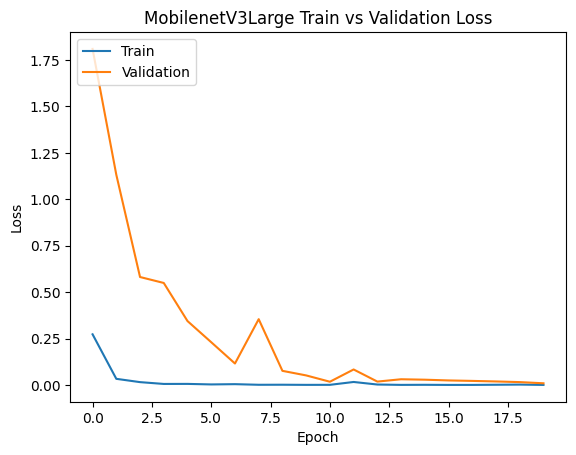

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobilenetV3Large Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

### Model Evaluation

In [14]:
test_path = 'dataset-classification/test-segmented'
test_generator = ImageDataGenerator().flow_from_directory(test_path, target_size=(img_size,img_size), shuffle=False)
predictions = model.predict(x = test_generator, verbose = 0)

Found 600 images belonging to 3 classes.


In [15]:
test_labels = test_generator.classes
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
test_generator.class_indices

{'-K': 0, '-N': 1, 'FN': 2}

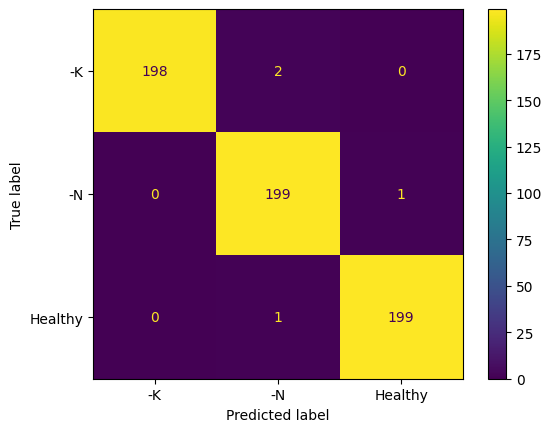

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-K', '-N', 'Healthy'])
disp.plot()
plt.show()

In [17]:
from sklearn.metrics import classification_report 

print(classification_report(test_labels,predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       200
           1       0.99      0.99      0.99       200
           2       0.99      0.99      0.99       200

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



### Save Model

In [18]:
model.save("models/MNetLarge.h5")

**Converting to TFlite**

In [20]:
model = tf.keras.models.load_model('models/MNetLarge.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('models/MNetLarge.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Justine\AppData\Local\Temp\tmpf6v6tyon\assets


INFO:tensorflow:Assets written to: C:\Users\Justine\AppData\Local\Temp\tmpf6v6tyon\assets
